# Problem Statement

We have a damped harmonic oscillator described by the ordinary differential equation 



$$
\frac{d^2 x}{dz^2} + 2\xi \frac{dx}{dz} + x = 0
$$

This equation is also known as the "Universal Oscillator Equation", since all second-order linear oscillatory systems can be reduced to this form.

The system starts with the initial conditions

$$
x(0) = 0.7,\ \frac{dx}{dz}(0) = 1.2
$$

and since we are considering the damping ratios $\xi$ in the range $\left [0.1, 0.4 \right]$, we’re in the **underdamped regime** (because $\xi < 1$). In this case, the system oscillates while its amplitude decays over time. The domain for solution is $z \in [0,20]$

# Analytical Solution



For the underdamped case, the general solution of the damped harmonic oscillator is given by $$x(z) = e^{-\xi z}[A \cos(w_{d}z) + B\sin(w_{d}z)]$$

where the damped natural frequency is $$w_{d} = \sqrt{ 1-\xi^2 }$$

## Determining the constants

### Initial Condition 1:

At $z = 0$: $$x(0) = e^0[A\cos(0) + B\sin(0)] = A = 0.7$$

so, $$A = x(0) = 0.7$$

### Initial Condition 2:

Differentiate $x(z)$ with respect to $z$:

$$\frac{dx}{dz} = -\xi e^{-\xi z}[A\cos(w_{d}z) + B\sin(w_{d}z)] + e^{-\xi z}[-Aw_{d}\sin(w_{d}z) + B w_{d}\cos(w_{d}z)]$$

At $z = 0$:

$$x'(0) = -\xi\ A + Bw_{d} = v_{0} = 1.2$$

Substitute $A = 0.7$:

$$-\xi(0.7) + Bw_{d} = 1.2 \implies B = \frac{{1.2 + 0.7\xi}}{w_{d}} = \frac{{1.2 + 0.7\xi}}{\sqrt{ 1 - \xi^2 }}$$

## Final Analytical Form

Thus, the solution is $$\boxed{x(z) = e^{-\xi z}\left[ 0.7\cos(\sqrt{ 1-\xi^2 }z)+\frac{{1.2 + 0.7\xi}}{\sqrt{ 1-\xi^2 }}\sin(\sqrt{ 1-\xi^2 }z) \right]}$$

This formula gives the position $x(z)$ at any point $z$ in the domain $[0,20]$ for a given damping ration $\xi$ in the range $[0.1, 0.4]$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Defining values
x0, v0 = 0.7, 1.2
xi_values = [0.1, 0.2, 0.3, 0.4]
z_min, z_max = 0, 20

Using device: cuda


In [2]:
def analytical_solution(z, xi, x0, v0):
    """Analytical solution for the underdamped harmonic oscillator"""
    omega_d = np.sqrt(1 - xi**2)

    return np.exp(-xi * z) * (
        x0 * np.cos(omega_d * z) + (v0 + xi * x0) / omega_d * np.sin(omega_d * z)
    )


Let's have a look at the curves we will be trying to fit 

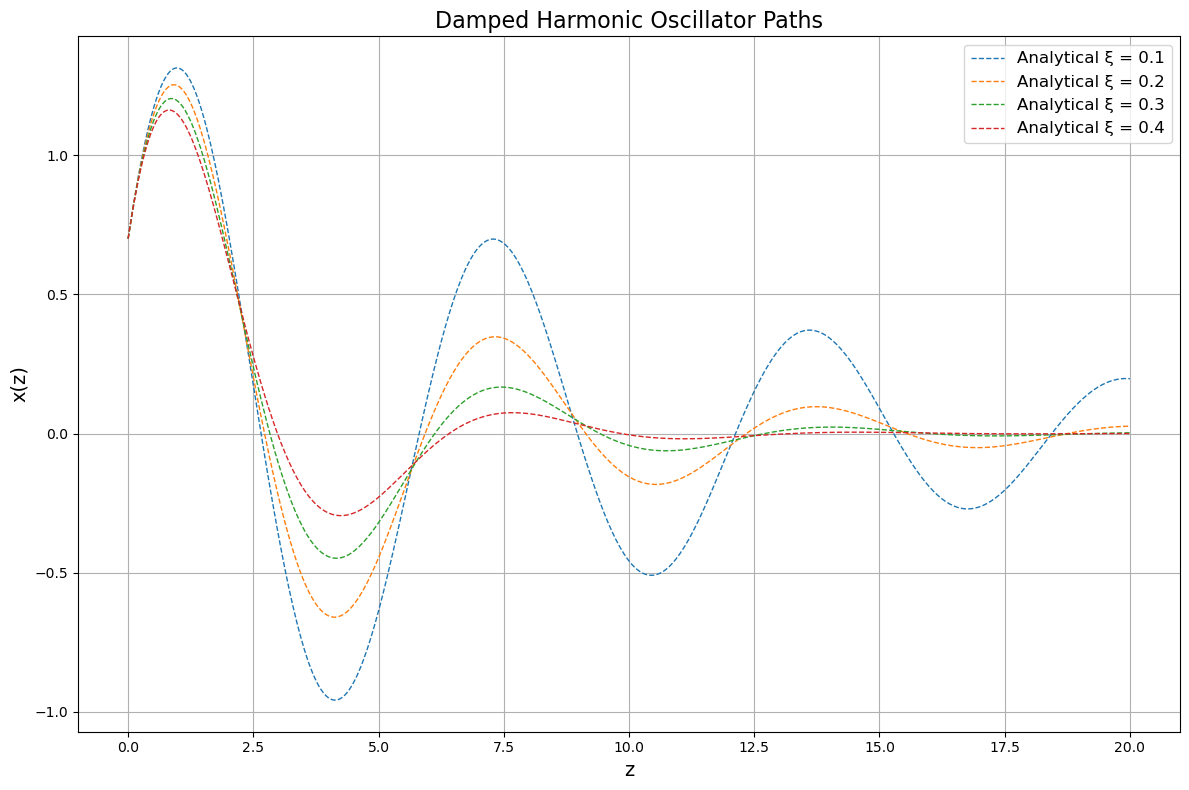

In [3]:
z = torch.linspace(z_min, z_max, 500).reshape(-1, 1).to(device)

# Create collocation points (adaptive sampling -> more points near z=0)
n_collocation = 1000
n_dense = int(0.6 * n_collocation)  # 60% of points in [0, 5]
n_sparse = n_collocation - n_dense  # 40% of points in [5, 20]

z_dense = torch.linspace(z_min, 5, n_dense)
z_sparse = torch.linspace(5, z_max, n_sparse)
z_collocation = (
    torch.cat([z_dense, z_sparse]).reshape(-1, 1).to(device).requires_grad_(True)
)


plt.figure(figsize=(12, 8))
for xi in xi_values:
    xi_tensor = xi * torch.ones_like(z).to(device)

    z_np = z.cpu().numpy().flatten()
    x_analytical = analytical_solution(z_np, xi, x0, v0)
    plt.plot(z_np, x_analytical, "--", label=f"Analytical ξ = {xi}", linewidth=1)


plt.title("Damped Harmonic Oscillator Paths", fontsize=16)
plt.xlabel("z", fontsize=14)
plt.ylabel("x(z)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


We are using **SIREN** architecutre for our PINNs. SIRENs use periodic sine activations instead of traditional ReLU/tanh, which help in modelling complex signals and their derivatives with high accuracy.

In [4]:
# Weight initialization
def init_weight(weight, omega=1, is_first=False):
    in_features = weight.shape[1]
    with torch.no_grad():
        bound = 1 / in_features if is_first else np.sqrt(6 / in_features) / omega
        weight.uniform_(-bound, bound)


# PINN architecture using SIREN (sine activation functions)
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=1, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)
        init_weight(self.linear.weight, omega=omega_0, is_first=is_first)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))


class PINN(nn.Module):
    def __init__(self, hidden_dim=100, num_layers=4, omega=1):
        super().__init__()

        layers = [SineLayer(2, hidden_dim, omega_0=omega, is_first=True)]
        layers.extend(
            [
                SineLayer(hidden_dim, hidden_dim, omega_0=omega)
                for _ in range(num_layers)
            ]
        )

        final_linear = nn.Linear(hidden_dim, 1)
        init_weight(final_linear.weight, omega=omega)
        layers.append(final_linear)

        self.net = nn.Sequential(*layers)


    def forward(self, z, xi):
        x = torch.cat([z, xi], dim=1)
        return self.net(x)


Now, lets calculate the derivatives and the losses. 
1. Physics-informed loss enforces the model to follow the governing ODE. It embeds the physical laws directly in the optimization.
2. Intial condition loss enforces the boundaries/intial constraints. It prevents trivial solutions to the ODE residual and pushes solutions to acknowledge known physical constraints.

In [5]:
def compute_derivatives(model, z, xi):
    z_tensor = z.clone().requires_grad_(True)
    xi_tensor = xi.clone()

    x = model(z_tensor, xi_tensor)

    # First derivative
    dx_dz = torch.autograd.grad(
        x,
        z_tensor,
        grad_outputs=torch.ones_like(x).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Second derivative
    d2x_dz2 = torch.autograd.grad(
        dx_dz,
        z_tensor,
        grad_outputs=torch.ones_like(dx_dz).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]

    return x, dx_dz, d2x_dz2


# Physics-informed loss function
def physics_loss(model, z_collocation, xi_values):
    loss = 0.0

    for xi in xi_values:
        xi_tensor = xi * torch.ones_like(z_collocation).to(device)

        # derivatives
        x, dx_dz, d2x_dz2 = compute_derivatives(
            model, z_collocation, xi_tensor.reshape(-1, 1)
        )

        # Residual of the differential equation
        residual = d2x_dz2 + 2 * xi * dx_dz + x

        loss += torch.mean(residual**2)

    return loss / len(xi_values)


# Initial condition loss function
def initial_condition_loss(model, xi_values, x0, v0):
    loss = 0.0

    x0_tensor = torch.tensor(x0, device=device)
    v0_tensor = torch.tensor(v0, device=device)

    for xi in xi_values:
        z_tensor = torch.zeros(1, 1, requires_grad=True, device=device)
        xi_tensor = torch.tensor([[xi]], dtype=torch.float32, device=device)

        x, dx_dz, _ = compute_derivatives(model, z_tensor, xi_tensor)

        # Loss for initial conditions
        loss_x0 = ((x - x0_tensor) ** 2).mean()
        loss_v0 = ((dx_dz - v0_tensor) ** 2).mean()

        loss += loss_x0 + loss_v0

    return loss / len(xi_values)

Let's define the training function, which can also print useful metrics like losses

In [6]:
# Training function
def train_pinn(model, optimizer, scheduler, n_epochs, z_collocation, xi_values, x0, v0):
    history = {"loss": [], "physics_loss": [], "ic_loss": []}

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        phys_loss = physics_loss(model, z_collocation, xi_values)
        ic_loss = initial_condition_loss(model, xi_values, x0, v0)
        loss = phys_loss + ic_loss

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        history["loss"].append(loss.item())
        history["physics_loss"].append(phys_loss.item())
        history["ic_loss"].append(ic_loss.item())

        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4e}, "
                f"Physics: {phys_loss.item():.4e}, IC: {ic_loss.item():.4e}"
            )
            z_test = torch.tensor([[0.0], [5.0], [10.0], [15.0]], device=device)
            for xi in xi_values[:1]:  # Just first xi for brevity
                xi_tensor = xi * torch.ones_like(z_test).to(device)
                with torch.no_grad():
                    x_pred = model(z_test, xi_tensor.reshape(-1, 1))
                print(
                    f"Predictions at z=[0,5,10,15], xi={xi}: {x_pred.cpu().numpy().flatten()}"
                )

    return history


Let's define some functions to plot the analytical v/s. predicted graphs, and to plot the losses over the course of training.

In [7]:
# Function to plot results
def plot_solutions(model, xi_values, z_min, z_max, x0, v0):
    z = torch.linspace(z_min, z_max, 500).reshape(-1, 1).to(device)

    plt.figure(figsize=(12, 8))
    for xi in xi_values:
        xi_tensor = xi * torch.ones_like(z).to(device)

        with torch.no_grad():
            x_pred = model(z, xi_tensor.reshape(-1, 1))

        # PINN prediction
        plt.plot(
            z.cpu().numpy(), x_pred.cpu().numpy(), label=f"PINN ξ = {xi}", linewidth=2
        )

        # analytical solution for comparison
        z_np = z.cpu().numpy().flatten()
        x_analytical = analytical_solution(z_np, xi, x0, v0)
        plt.plot(z_np, x_analytical, "--", label=f"Analytical ξ = {xi}", linewidth=1)

    plt.title("Damped Harmonic Oscillator Solutions", fontsize=16)
    plt.xlabel("z", fontsize=14)
    plt.ylabel("x(z)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Function to plot losses
def plot_losses(history):
    plt.figure(figsize=(10, 6))
    plt.semilogy(history["loss"], label="Total Loss")
    plt.semilogy(history["physics_loss"], label="Physics Loss")
    plt.semilogy(history["ic_loss"], label="Initial Condition Loss")
    plt.title("Training Losses", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss (log scale)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Now, let's bring everything together and start the training!

In [8]:
n_epochs = 7000
learning_rate = 0.001

model = PINN(hidden_dim=128, num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=100, factor=0.5, verbose=True
)

history = train_pinn(
    model, optimizer, scheduler, n_epochs, z_collocation, xi_values, x0, v0
)


/home/yukinatsu/miniconda3/envs/torch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/yukinatsu/miniconda3/envs/torch/lib/python3.12/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1737241548806/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/7000], Loss: 8.0164e-03, Physics: 5.4531e-03, IC: 2.5633e-03
Predictions at z=[0,5,10,15], xi=0.1: [ 0.7474297  -0.53126925 -0.21060914  0.02236447]
Epoch [200/7000], Loss: 3.7231e-03, Physics: 1.9554e-03, IC: 1.7677e-03
Predictions at z=[0,5,10,15], xi=0.1: [ 0.75788325 -0.4794868  -0.15998599  0.06845342]
Epoch [300/7000], Loss: 4.0543e-03, Physics: 1.5190e-03, IC: 2.5352e-03
Predictions at z=[0,5,10,15], xi=0.1: [ 0.65786105 -0.6247562  -0.27188265  0.05287679]
Epoch [400/7000], Loss: 2.6450e-04, Physics: 2.6273e-04, IC: 1.7698e-06
Predictions at z=[0,5,10,15], xi=0.1: [ 0.698866   -0.61233246 -0.3084681   0.07037422]
Epoch [500/7000], Loss: 2.2612e-04, Physics: 2.2443e-04, IC: 1.6833e-06
Predictions at z=[0,5,10,15], xi=0.1: [ 0.69879746 -0.61694884 -0.3199528   0.0733603 ]
Epoch [600/7000], Loss: 2.0180e-04, Physics: 2.0056e-04, IC: 1.2434e-06
Predictions at z=[0,5,10,15], xi=0.1: [ 0.6989396  -0.62067634 -0.32480517  0.07432298]
Epoch [700/7000], Loss: 1.8515e-04, Phys

Let's have a look at the predicted curves

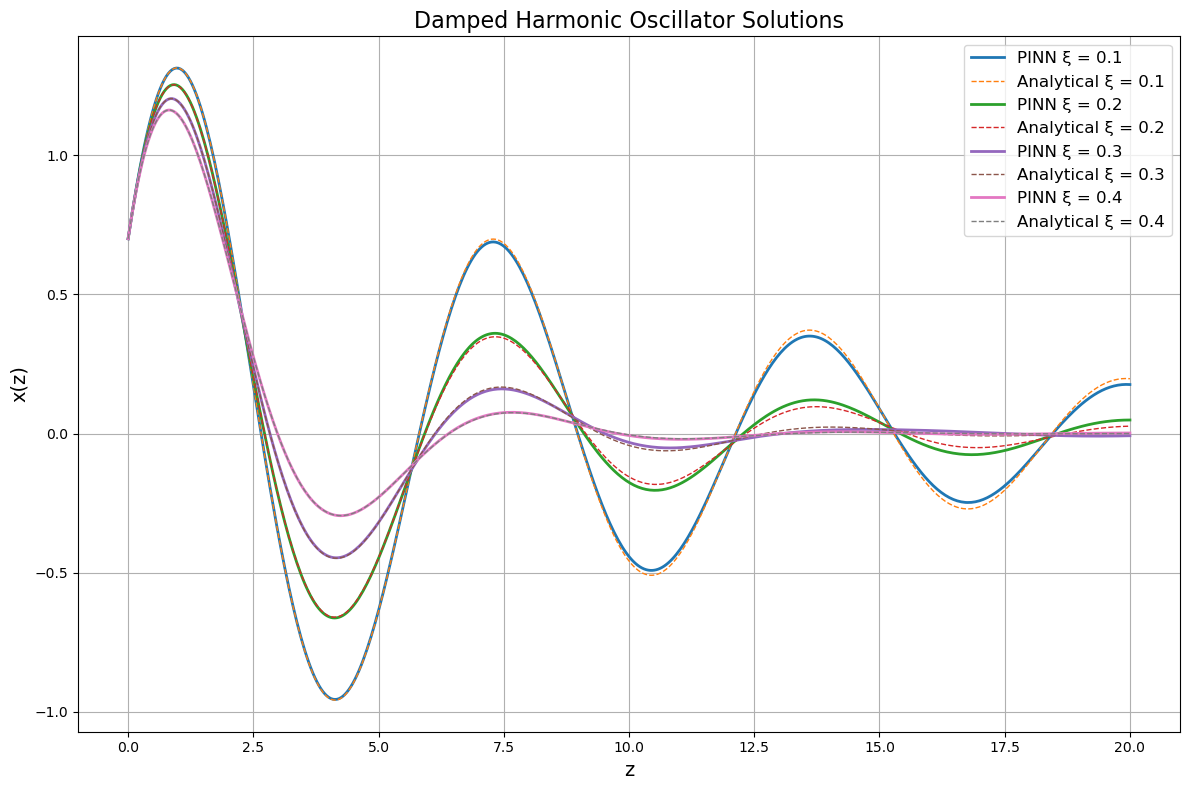

In [9]:
plot_solutions(model, xi_values, z_min, z_max, x0, v0)

As we can see, the PINN has beautifully fit the curves with high accuracy in just 7000 epochs. We can get an even better accuracy by increasing the number of epochs. 

To achieve futher speedups, we can use "Separable PINN". Here, instead of feeding every multi-dimensional coordinate into a single MLP, e.g. f(x1, x2, x3), we use factorized coordinates and separated sub-networks, where each sub-network takes independent one-dimensional coordinates as input,e.g. f1(x1), f2(x2), f3(x3). The final output is generated by a simple outer product and element-wise summation.

But for this notebook, we will continute with SIREN model.

Let's have a look at the losses during training

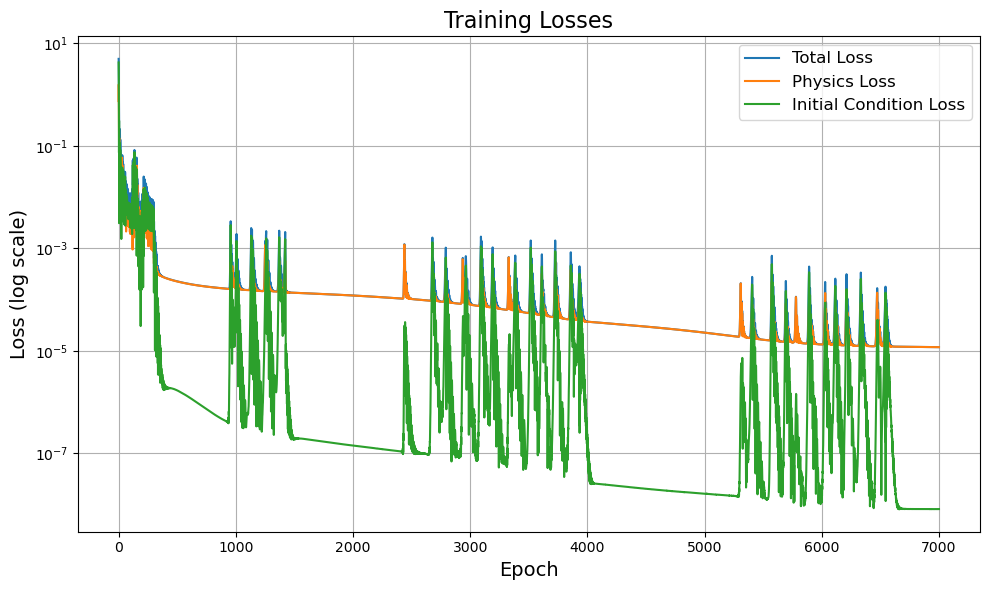

In [10]:
plot_losses(history)

The losses stabilize early because collocation points near $z=0$ provide dense sampling, helping the model capture critical dynamics.

We can observe periodic spikes in the losses, probably because the higher derivatives are more sensitive to weight updates. Also, adaptive sampling near $z=0$ amplifies sensitivity since small errors in derivatives can disproportionately affect loss value.

Learning rate schedules or optimizer dynamics (e.g., Adam's momentum terms) can also introduce oscillatory behavior.